<a href="https://colab.research.google.com/github/trollmannen/Data-Science/blob/main/Twitch-Chat-EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [57]:
CLIENT_ID = ''
CLIENT_SECRET = ''

In [3]:
#!pip install -e git+https://github.com/sotif/Twitch-Python.git@master#egg=Twitch-Python

In [4]:
import twitch
helix = twitch.Helix(CLIENT_ID, CLIENT_SECRET)

## Part 1: Gather & Store Data

In [5]:
from tqdm import tqdm
def get_chats(vod_ids):
  chats = []
  meta = {}

  for video, comments in helix.videos(vod_ids).comments:
    meta[int(video.id)] = video.data
    for comment in tqdm(comments):
      chats.append((comment.created_at,
                    comment.commenter.display_name,
                    comment.message.body,
                    comment.content_offset_seconds,
                    video.id))

  chats = pd.DataFrame(columns=['timestamp',
                                'username',
                                'message',
                                'seconds',
                                'vod_id'],
                       data=chats)
  return chats,meta

In [6]:
def get_latest_chats(streamers,n):
  chats = []
  meta = {}

  for user, videos in helix.users(streamers).videos(first=n):
    for video, comments in videos.comments:
      meta[int(video.id)] = video.data
      for comment in tqdm(comments):
        chats.append((comment.created_at,
                      comment.commenter.display_name,
                      comment.message.body,
                      comment.content_offset_seconds,
                      video.id))

  chats = pd.DataFrame(columns=['timestamp',
                                'username',
                                'message',
                                'seconds',
                                'vod_id'],
                       data=chats)
  return chats,meta

In [7]:
#chats,meta = get_chats([1454475889])
chats,meta = get_latest_chats(['xqcow'],1)

683592it [28:40, 397.42it/s]


In [8]:
chats.to_csv('chats.csv',index=False)

In [9]:
#from google.colab import drive
#drive.mount('/content/drive')

In [10]:
#!cp -r 'chats.csv' /content/drive/MyDrive/twitch/

## Part 2: Clean & Organize Data

In [37]:
chats = pd.read_csv('chats.csv')
#chats = pd.read_csv('/content/drive/MyDrive/twitch/chats.csv', index_col='timestamp', parse_dates=True)

In [38]:
chats['delta'] = pd.to_timedelta(chats['seconds'],unit="s")

In [39]:
chats.index = chats['delta']

In [40]:
chats = chats.drop(['timestamp','delta'],axis=1)

## Part 3: EDA

### What does the dataset look like?

In [41]:
chats

,username,message,seconds,vod_id
delta,,,,
0 days 00:00:00.331000,Tywow328,PotFriend PotFriend PotFriend PotFriend PotFri...,0.331,1466332523
0 days 00:00:00.450000,tinivy_,AlienPls3 go live please mr cow,0.450,1466332523
0 days 00:00:00.522000,torpid00,POT EMOTERS,0.522,1466332523
0 days 00:00:00.979000,salvationdota,xqcDespair,0.979,1466332523
0 days 00:00:01.045000,TheHesser,TriHard TeaTime,1.045,1466332523
...,...,...,...,...
0 days 20:31:28.276000,SchnozeBot,thonkthinkthinkthonk won 1000 points in roulet...,73888.276,1466332523
0 days 20:31:28.442000,Fossabot,xqcL MrAstronaut13 is staying in the jungle us...,73888.442,1466332523
0 days 20:31:28.685000,SchnozeBot,cmistyyyyyyyyyyyyyyyy lost 5000 points in roul...,73888.685,1466332523


In [42]:
vod_id = chats.iloc[0]['vod_id']

### Who's the streamer?

In [43]:
meta[vod_id]['user_name']

'xQcOW'

### What is the stream title?

In [44]:
meta[vod_id]['title']

'📈CLICK FAST📈ACTUAL DRAMA📈BIG NEWS AND FACTS📈AMAZING INSANE CONTENT📈SICK VIDEOS AND MEGA GAMES📈UR STILL READING THIS ARENT YOU, GNOME📈'

### How many unique viewers have watched parts of this stream?

In [45]:
meta[vod_id]['view_count']

96899

### How long did the stream last?

In [46]:
meta[vod_id]['duration']

'20h31m10s'

### How many chat messages were banned?

In [47]:
len(chats[chats['message'].isnull()])

13

In [48]:
chats = chats.dropna()

### How many funny moments were there?

In [49]:
laughing = chats.loc[chats['message'].str.contains("lul|kek", case=False)].resample(rule='min').count()

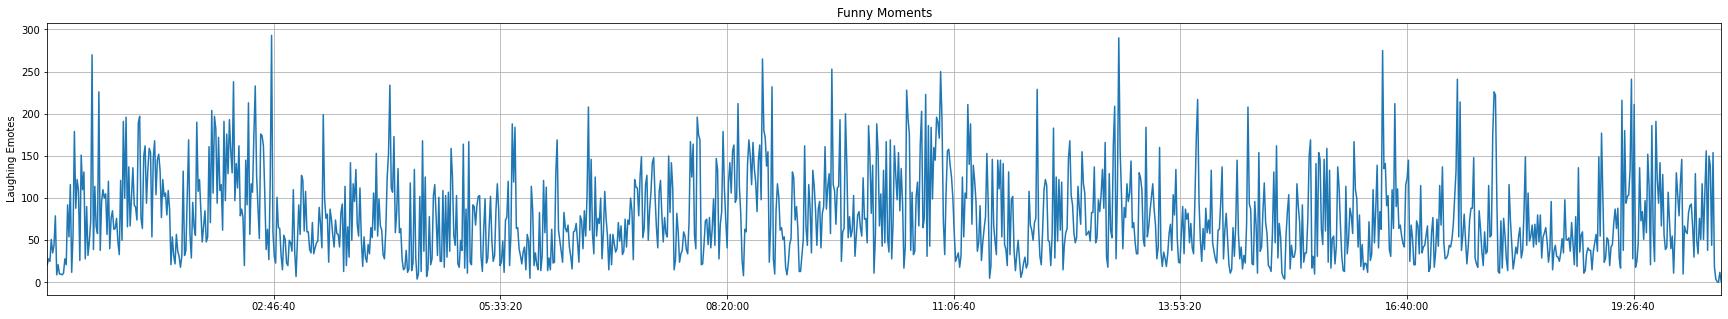

In [50]:
from matplotlib import dates
title='Funny Moments'
ylabel='Laughing Emotes'
xlabel=''

ax = laughing['message'].plot(figsize=(30,5),title=title)#,x_compat=True)

ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
#ax.xaxis.set_major_locator(dates.HourLocator())
#ax.xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax.yaxis.grid(True)
ax.xaxis.grid(True)

In [51]:
funny_moments = laughing[laughing['message'] > 250]['message']

In [52]:
len(funny_moments)

6

### When did the funny moments occur?

In [53]:
funny_moments.sort_values(ascending=False)

delta
0 days 02:45:07.906000    293
0 days 13:08:07.906000    290
0 days 16:22:07.906000    275
0 days 00:33:07.906000    270
0 days 08:46:07.906000    265
0 days 09:37:07.906000    253
Name: message, dtype: int64

## Extras

In [54]:
helix.video(1456101444).data

{'created_at': '2022-04-14T22:10:11Z',
 'description': '',
 'duration': '13h20m32s',
 'id': '1456101444',
 'language': 'en',
 'muted_segments': None,
 'published_at': '2022-04-14T22:10:11Z',
 'stream_id': '46171442765',
 'thumbnail_url': 'https://static-cdn.jtvnw.net/cf_vods/d1m7jfoe9zdc1j/6c8895747d1c4f34dd23_xqcow_46171442765_1649974205//thumb/thumb0-%{width}x%{height}.jpg',
 'title': '🔴CLICK FAST🔴BIG JUICER🔴#1 WORLD AT ALL🔴DRAMA ONLY🔴BIG NEWS🔴CRAZY CONTENT🔴OMG🔴DONT MISS IT🔴9845U4895738978593🔴9878935789578🔴487🔴',
 'type': 'archive',
 'url': 'https://www.twitch.tv/videos/1456101444',
 'user_id': '71092938',
 'user_login': 'xqcow',
 'user_name': 'xQcOW',
 'view_count': 2765435,
 'viewable': 'public'}

In [55]:
helix.user('xqcow').data

{'broadcaster_type': 'partner',
 'created_at': '2014-09-12T23:50:05Z',
 'description': 'THE BEST AT ABSOLUTELY EVERYTHING. THE JUICER. LEADER OF THE JUICERS.',
 'display_name': 'xQcOW',
 'id': '71092938',
 'login': 'xqcow',
 'offline_image_url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/dc330b28-9c9f-4df4-b8b6-ff56b3c094fd-channel_offline_image-1920x1080.png',
 'profile_image_url': 'https://static-cdn.jtvnw.net/jtv_user_pictures/xqcow-profile_image-9298dca608632101-300x300.jpeg',
 'type': '',
 'view_count': 524730962}

In [56]:
helix.user('xqcow').is_live

False